In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os,cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [7]:
#Reading the data set
p = '/content/drive/My Drive/CK+48'
data_dir_list = os.listdir(p)
arrayListData=[]
for d in data_dir_list:
    images=os.listdir(p+'/'+ d)
    print ('Loading images of -'+'{}\n'.format(d))
    for i in images:
        take=cv2.imread(p + '/'+ d + '/'+ i )
        take1=cv2.resize(take,(48,48))
        arrayListData.append(take1)
        
d1 = np.array(arrayListData)
d1 = d1.astype('float32')
d1 = d1/255

Loading images of -happy

Loading images of -anger

Loading images of -sadness

Loading images of -contempt

Loading images of -fear

Loading images of -disgust

Loading images of -surprise



In [8]:
num_classes = 7

samples = d1.shape[0]
labels = np.ones((samples,),dtype='int64')

labels[0:134]=0
labels[135:188]=1
labels[189:365]=2
labels[366:440]=3
labels[441:647]=4
labels[648:731]=5
labels[732:980]=6

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [10]:
Y = utils.to_categorical(labels, num_classes)


x,y = shuffle(d1,Y, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)
print(X_test.shape)
print(X_train.shape)

(148, 48, 48, 3)
(833, 48, 48, 3)


In [11]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten


model = Sequential()
input_shape = (48,48,3)
# 1st convolution layer
model.add(Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9,patience=3,verbose=1)
modelF = model.fit(X_train, y_train, epochs=65, batch_size=64,
          validation_data=(X_test, y_test), shuffle=True, verbose=1,callbacks = [lr_reducer])


Epoch 1/65
14/14 [==============================] - 9s 547ms/step - loss: 1.8861 - accuracy: 0.2149 - val_loss: 1.7953 - val_accuracy: 0.3176
Epoch 2/65
14/14 [==============================] - 7s 530ms/step - loss: 1.8718 - accuracy: 0.2509 - val_loss: 1.7951 - val_accuracy: 0.3176
Epoch 3/65
14/14 [==============================] - 7s 526ms/step - loss: 1.8119 - accuracy: 0.3061 - val_loss: 1.5244 - val_accuracy: 0.3716
Epoch 4/65
14/14 [==============================] - 7s 527ms/step - loss: 1.4749 - accuracy: 0.4274 - val_loss: 1.1935 - val_accuracy: 0.4730
Epoch 5/65
14/14 [==============================] - 7s 527ms/step - loss: 1.2816 - accuracy: 0.5018 - val_loss: 1.0588 - val_accuracy: 0.5878
Epoch 6/65
14/14 [==============================] - 7s 526ms/step - loss: 1.1370 - accuracy: 0.5774 - val_loss: 1.1049 - val_accuracy: 0.5473
Epoch 7/65
14/14 [==============================] - 7s 527ms/step - loss: 1.1371 - accuracy: 0.5594 - val_loss: 0.9080 - val_accuracy: 0.6622
Epoch 

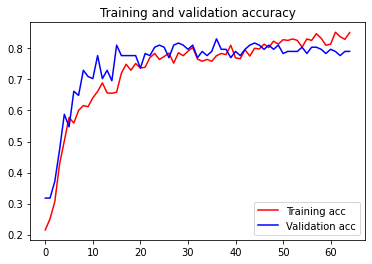

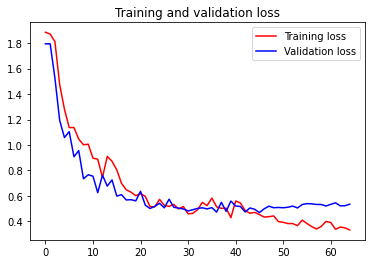

In [12]:
import matplotlib.pyplot as plt

accuracy = modelF.history['accuracy']
val_accuracy = modelF.history['val_accuracy']
loss = modelF.history['loss']
validation_loss = modelF.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# evaluate model on private test set
acc = model.evaluate(X_test, y_test, verbose=1)
print ("model %s: %.2f%%" % (model.metrics_names[1], acc[1]*100))

5/5 [==============================] - 0s 68ms/step - loss: 0.5712 - accuracy: 0.8243
model accuracy: 82.43%


16/16 [==============================] - 2s 135ms/step


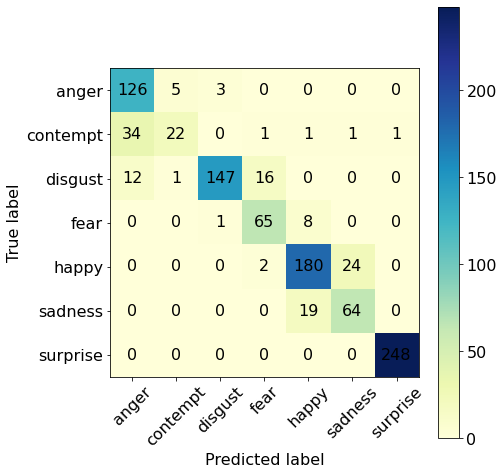

In [ ]:
import matplotlib
from sklearn.metrics import confusion_matrix

# prediction and true labels

y_prob = model.predict(x, batch_size=64, verbose=1)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(names))
    ax.set_xticks(ticks)
    ax.set_xticklabels(names, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

3/3 [==============================] - 0s 96ms/step


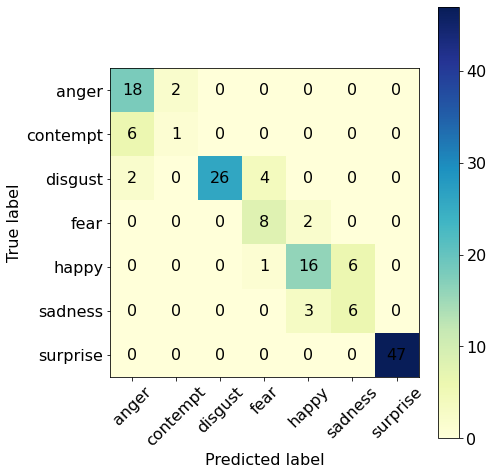

In [ ]:
# prediction and true labels
y_prob = model.predict(X_test, batch_size=64, verbose=1)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    ticks = np.arange(len(names))
    ax.set_xticks(ticks)
    ax.set_xticklabels(names, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)
plt.show()

148
148


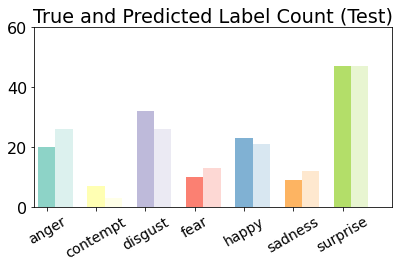

In [ ]:
import brewer2mpl

def plot_distribution2(y_true, y_pred):
    
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    ind = np.arange(1.5,8,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.set_xticks(np.arange(1.5,8,1))
    ax.set_xticklabels(names, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 8.5])
    ax.set_ylim([0, 60])
    ax.set_title('True and Predicted Label Count (Test)')
    plt.tight_layout()
    plt.show()


print(len(y_true))
print(len(y_pred)) 
plot_distribution2(y_true, y_pred)